### AI5100 Deep Learning Assignment 4

1. Autoencoders: In this task, consider the MNIST dataset for training autoencoder models (with
a suitable regularization) with hidden (latent) dimension of 32, and 64. [10 + 5 = 15 Marks]

In [18]:
# making autoencoder model

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from numpy import random


In [19]:
def add_noise(image, noise_factor):
    gaussian_noise = random.normal(0, noise_factor, image.size())
    gaussian_noise = torch.from_numpy(gaussian_noise).float().cuda()
    return image + gaussian_noise

In [20]:
# autoencoder model

class encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(encoder, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return x

class decoder(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(decoder, self).__init__()
        self.fc2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = torch.sigmoid(self.fc2(x))
        return x

In [21]:
enc = encoder(784, 64)
dec = decoder(64, 784)

# test input
x = torch.randn(784)
print(x.size())
print(enc(x).size())
print(dec(enc(x)).size())  

torch.Size([784])
torch.Size([64])
torch.Size([784])


In [22]:
class autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(autoencoder, self).__init__()
        self.encoder = encoder(input_size, hidden_size)
        self.decoder = decoder(hidden_size, input_size)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [23]:
# params:
batch_size = 32
learning_rate = 1e-4
num_epochs = 10

# Load the MNIST dataset

transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size= batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size= batch_size, shuffle=False)

In [24]:
# training the model
model = autoencoder(784, 32)
model = model.cuda()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
train_loss = []

for epoch in range(num_epochs):
    for i, data in enumerate(train_loader):

        img, _ = data
        img = img.view(img.size(0), -1)
        img = img.cuda()

        noisy_image = add_noise(img, 0.2)

        output = model(noisy_image)
        loss = criterion(output, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 500 == 0:
            print(f'Epoch: {epoch+1}, Step: {i + 1}, Loss: {loss.item()}')
            train_loss.append(loss.item())

Epoch: 1, Step: 500, Loss: 0.07424242794513702
Epoch: 1, Step: 1000, Loss: 0.06257771700620651
Epoch: 1, Step: 1500, Loss: 0.05360395833849907
Epoch: 2, Step: 500, Loss: 0.0415538027882576
Epoch: 2, Step: 1000, Loss: 0.039715345948934555
Epoch: 2, Step: 1500, Loss: 0.03851911425590515
Epoch: 3, Step: 500, Loss: 0.039067018777132034
Epoch: 3, Step: 1000, Loss: 0.03595804050564766
Epoch: 3, Step: 1500, Loss: 0.02981708012521267
Epoch: 4, Step: 500, Loss: 0.03333960473537445
Epoch: 4, Step: 1000, Loss: 0.02474954165518284
Epoch: 4, Step: 1500, Loss: 0.028335580602288246
Epoch: 5, Step: 500, Loss: 0.023714199662208557
Epoch: 5, Step: 1000, Loss: 0.02823890931904316
Epoch: 5, Step: 1500, Loss: 0.022364165633916855
Epoch: 6, Step: 500, Loss: 0.02376384288072586
Epoch: 6, Step: 1000, Loss: 0.02212911657989025
Epoch: 6, Step: 1500, Loss: 0.025178465992212296
Epoch: 7, Step: 500, Loss: 0.0224094670265913
Epoch: 7, Step: 1000, Loss: 0.018068892881274223
Epoch: 7, Step: 1500, Loss: 0.018877357244

(a) Report the train and test reconstruction errors for the three models (display about 10 recon-
structions from the train and test data each).

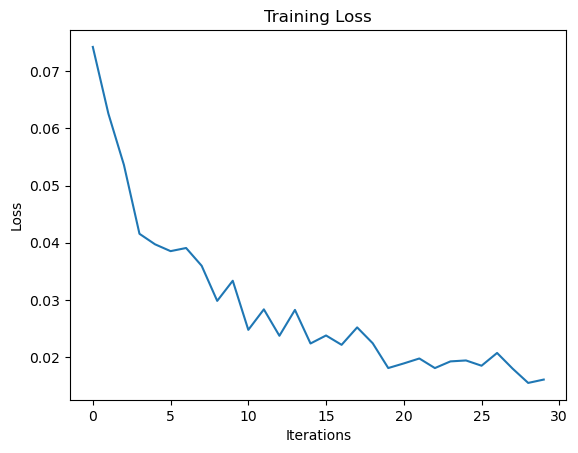

Test Loss: 0.014977292493937876
From train dataset


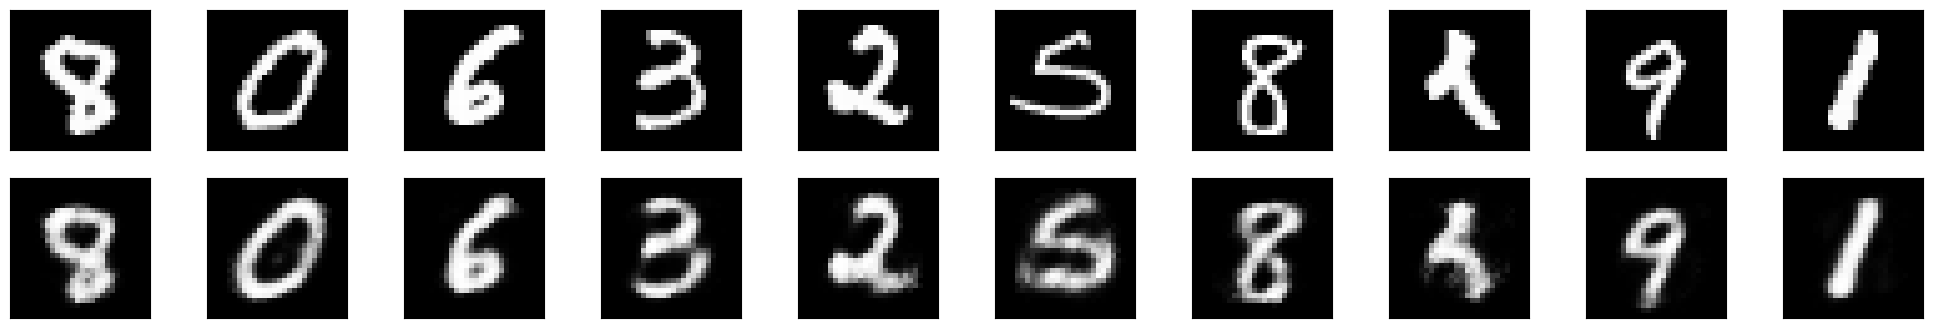

From test dataset


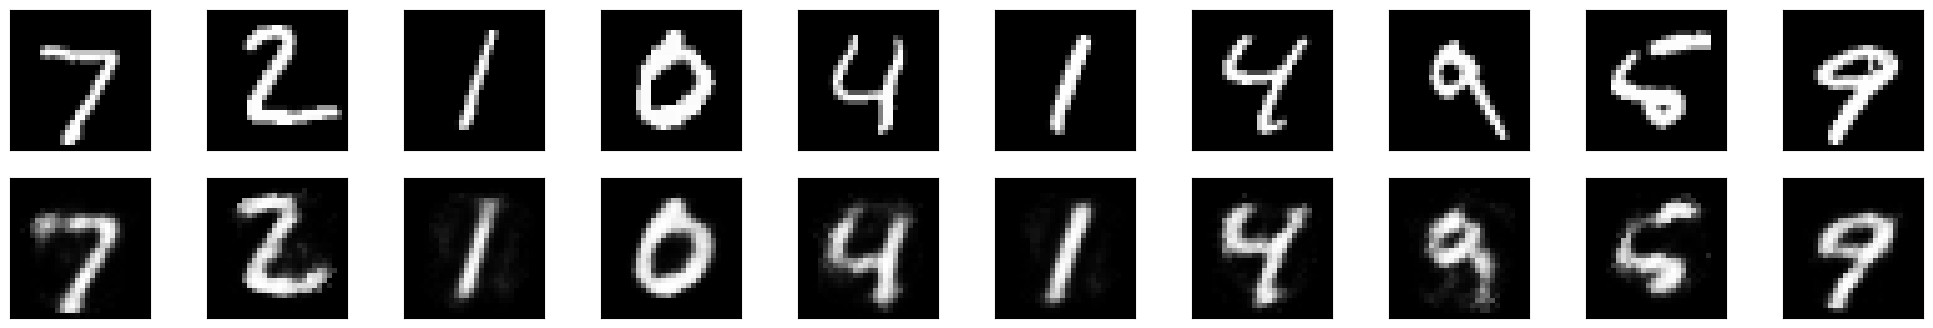

In [25]:
# report train and test reconstruction errors

plt.plot(train_loss)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# test the model

model.eval()
test_loss = []
with torch.no_grad():
    for data in test_loader:
        img, _ = data
        img = img.view(img.size(0), -1)
        img = img.cuda()
        
        output = model(img)
        loss = criterion(output, img)
        test_loss.append(loss.item())
        
    print(f'Test Loss: {np.mean(test_loss)}')

# visualize the reconstruction
print("From train dataset")
model.eval()
with torch.no_grad():
    img, _ = next(iter(train_loader))
    img = img.view(img.size(0), -1)
    img = img.cuda()
    
    output = model(img)
    
    original = img.view(-1, 28, 28).cpu().numpy()
    reconstructed = output.view(-1, 28, 28).cpu().numpy()
    
    fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))
    
    for images, row in zip([original, reconstructed], axes):
        for img, ax in zip(images, row):
            ax.imshow(np.squeeze(img), cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            
    plt.show()

print('From test dataset')
model.eval()
with torch.no_grad():
    img, _ = next(iter(test_loader))
    img = img.view(img.size(0), -1)
    img = img.cuda()
    
    output = model(img)
    
    original = img.view(-1, 28, 28).cpu().numpy()
    reconstructed = output.view(-1, 28, 28).cpu().numpy()
    
    fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))
    
    for images, row in zip([original, reconstructed], axes):
        for img, ax in zip(images, row):
            ax.imshow(np.squeeze(img), cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            
    plt.show()
    

(b) Perform the reconstruction on the line joining two training data samples in the hidden space.
Consider at least 5 pairs of samples.

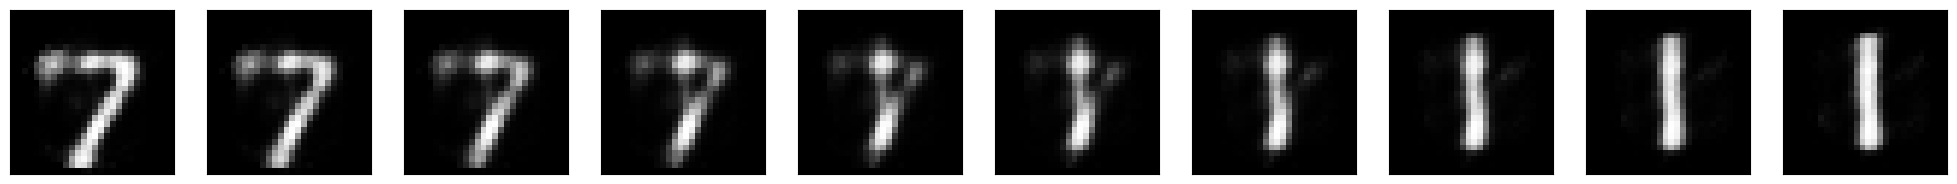

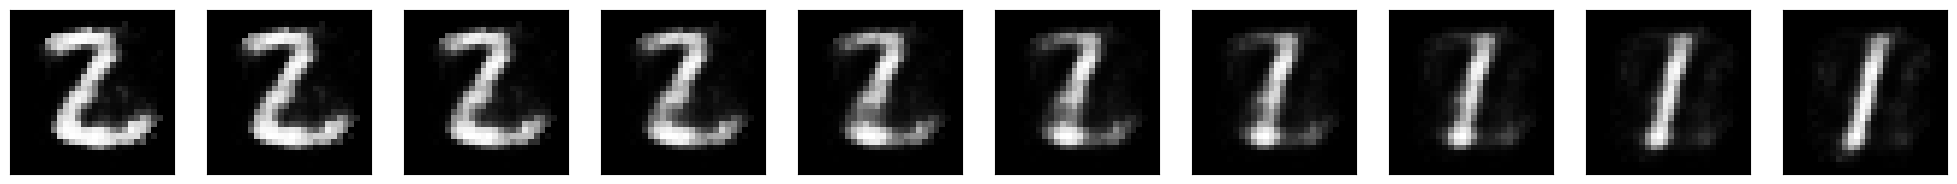

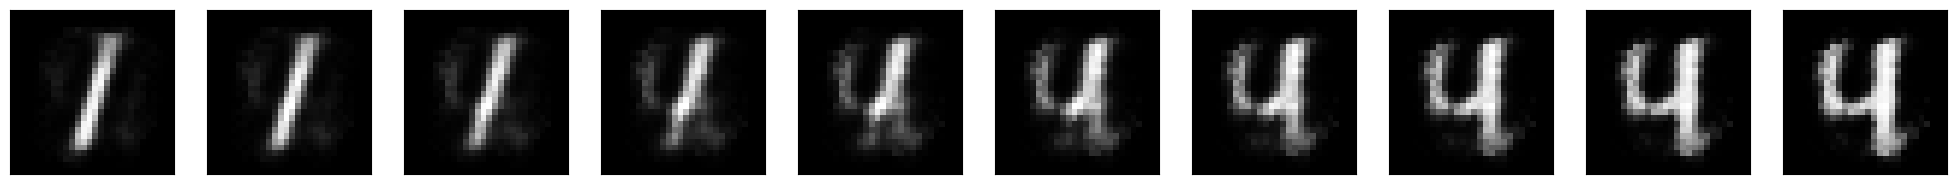

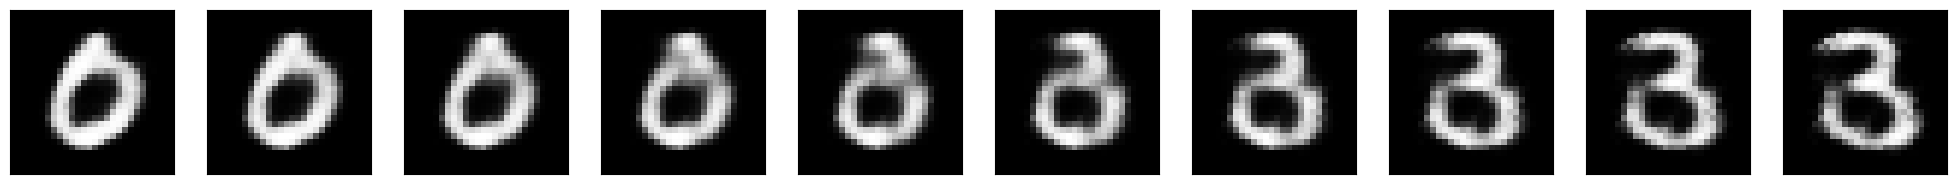

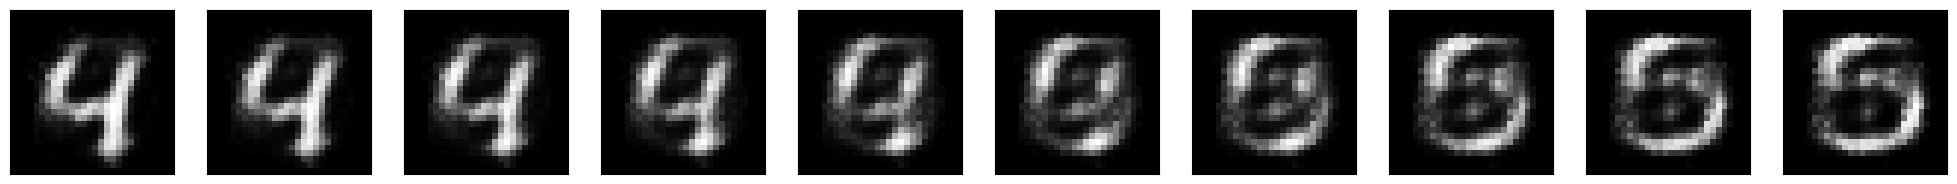

In [26]:
# reconstruction along a line joining 2 data samples in the hidden space

def plot_reconstruction(model, img1, img2, size = 32):
    z1 = model.encoder(img1)
    z2 = model.encoder(img2)

    z1 = z1.squeeze()
    z2 = z2.squeeze()

    n = 10
    z = torch.zeros(n, size).cuda()
    
    for i in range(n):
        z[i] = z1 * (n - i - 1) / (n - 1) + z2 * i / (n - 1)
        
    output = model.decoder(z)
    
    output = output.view(-1, 28, 28).cpu().numpy()
    
    fig, axes = plt.subplots(nrows=1, ncols=n, sharex=True, sharey=True, figsize=(25,4))
    
    for img, ax in zip(output, axes):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
    plt.show()
model.eval()

with torch.no_grad():
    img1, _ = next(iter(test_loader))
    img2, _ = next(iter(train_loader))

    #take only 5 images
    img1 = img1[:5]
    img2 = img2[:5]
    
    img1 = img1.view(img1.size(0), -1)
    img2 = img2.view(img2.size(0), -1)
    
    img1 = img1.cuda()
    img2 = img2.cuda()
    for i in range(5):
        plot_reconstruction(model, img1[i], img2[i])
    

In [27]:
# training the model

model = autoencoder(784, 64)
model = model.cuda()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
train_loss = []

for epoch in range(num_epochs):
    for i, data in enumerate(train_loader):

        img, _ = data
        img = img.view(img.size(0), -1)
        img = img.cuda()

        noisy_image = add_noise(img, 0.2)

        output = model(noisy_image)
        loss = criterion(output, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 500 == 0:
            print(f'Epoch: {epoch+1}, Step: {i + 1}, Loss: {loss.item()}')
            train_loss.append(loss.item())

Epoch: 1, Step: 500, Loss: 0.06920914351940155
Epoch: 1, Step: 1000, Loss: 0.05174943804740906
Epoch: 1, Step: 1500, Loss: 0.04167936369776726
Epoch: 2, Step: 500, Loss: 0.034150805324316025
Epoch: 2, Step: 1000, Loss: 0.03630450740456581
Epoch: 2, Step: 1500, Loss: 0.03219323232769966
Epoch: 3, Step: 500, Loss: 0.02817998081445694
Epoch: 3, Step: 1000, Loss: 0.024611664935946465
Epoch: 3, Step: 1500, Loss: 0.024422649294137955
Epoch: 4, Step: 500, Loss: 0.019507935270667076
Epoch: 4, Step: 1000, Loss: 0.01918337680399418
Epoch: 4, Step: 1500, Loss: 0.019042251631617546
Epoch: 5, Step: 500, Loss: 0.013984478078782558
Epoch: 5, Step: 1000, Loss: 0.015593195334076881
Epoch: 5, Step: 1500, Loss: 0.01601669006049633
Epoch: 6, Step: 500, Loss: 0.013983720913529396
Epoch: 6, Step: 1000, Loss: 0.014107161201536655
Epoch: 6, Step: 1500, Loss: 0.012303981930017471
Epoch: 7, Step: 500, Loss: 0.009816865436732769
Epoch: 7, Step: 1000, Loss: 0.011269507929682732
Epoch: 7, Step: 1500, Loss: 0.01252

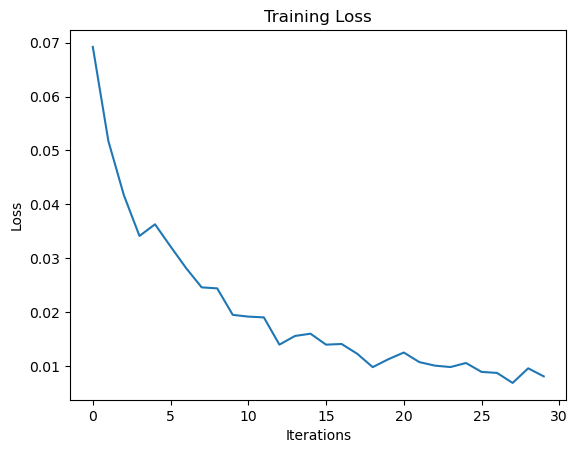

Test Loss: 0.007200342867844782
From train dataset


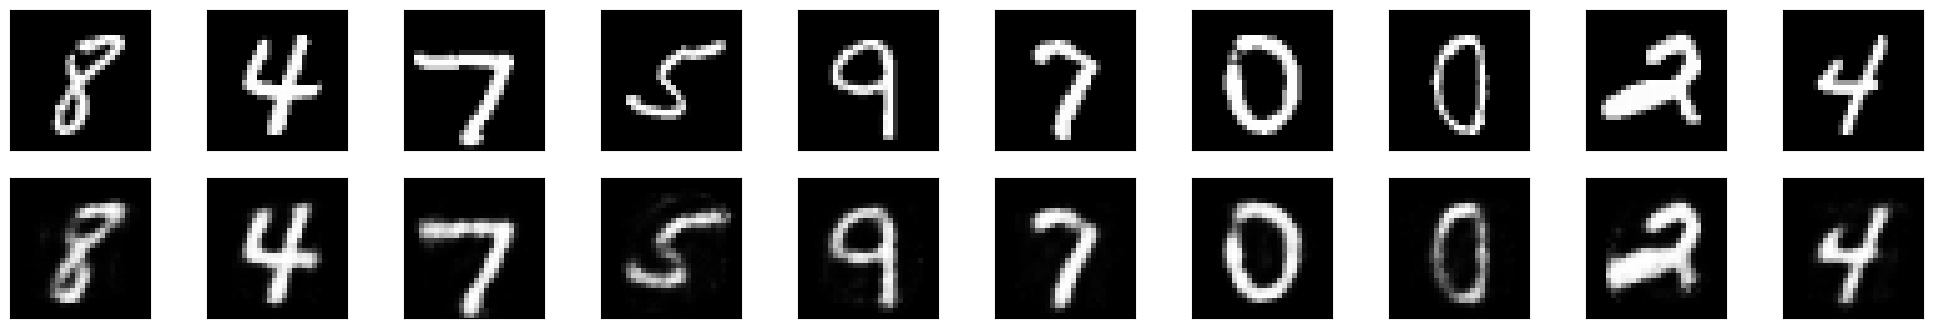

From test dataset


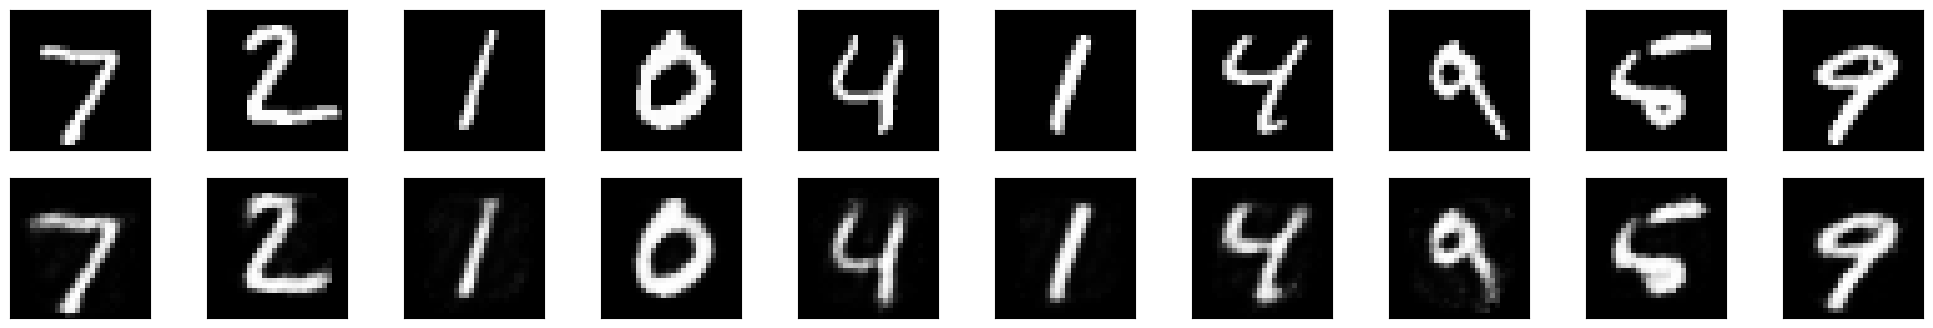

In [28]:
# report train and test reconstruction errors

plt.plot(train_loss)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# test the model

model.eval()
test_loss = []
with torch.no_grad():
    for data in test_loader:
        img, _ = data
        img = img.view(img.size(0), -1)
        img = img.cuda()
        
        output = model(img)
        loss = criterion(output, img)
        test_loss.append(loss.item())
        
    print(f'Test Loss: {np.mean(test_loss)}')

# visualize the reconstruction
print("From train dataset")
model.eval()
with torch.no_grad():
    img, _ = next(iter(train_loader))
    img = img.view(img.size(0), -1)
    img = img.cuda()
    
    output = model(img)
    
    original = img.view(-1, 28, 28).cpu().numpy()
    reconstructed = output.view(-1, 28, 28).cpu().numpy()
    
    fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))
    
    for images, row in zip([original, reconstructed], axes):
        for img, ax in zip(images, row):
            ax.imshow(np.squeeze(img), cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            
    plt.show()

print('From test dataset')
model.eval()
with torch.no_grad():
    img, _ = next(iter(test_loader))
    img = img.view(img.size(0), -1)
    img = img.cuda()
    
    output = model(img)
    
    original = img.view(-1, 28, 28).cpu().numpy()
    reconstructed = output.view(-1, 28, 28).cpu().numpy()
    
    fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))
    
    for images, row in zip([original, reconstructed], axes):
        for img, ax in zip(images, row):
            ax.imshow(np.squeeze(img), cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            
    plt.show()

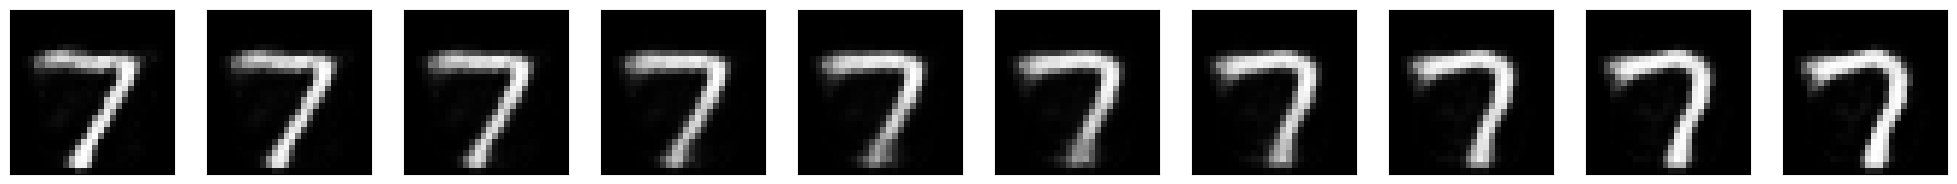

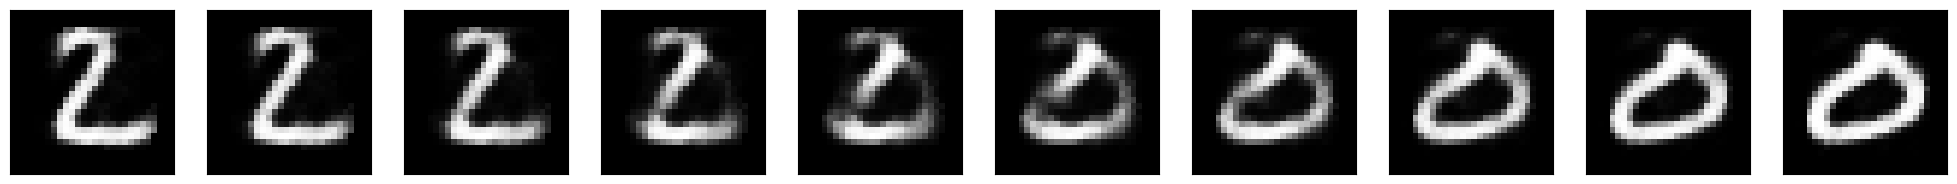

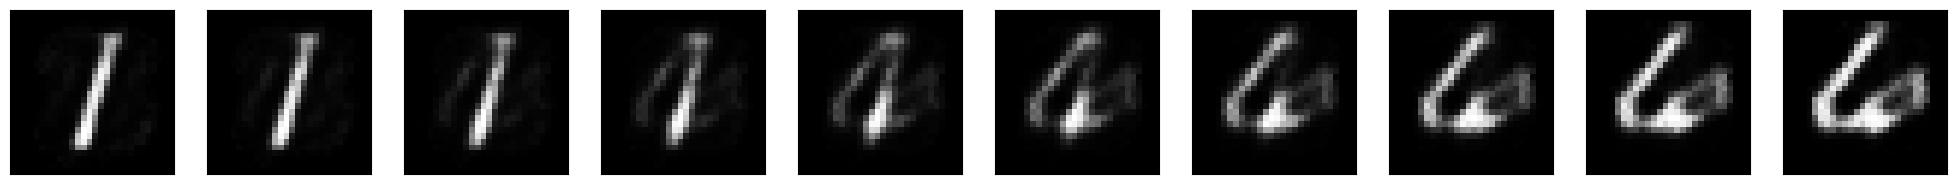

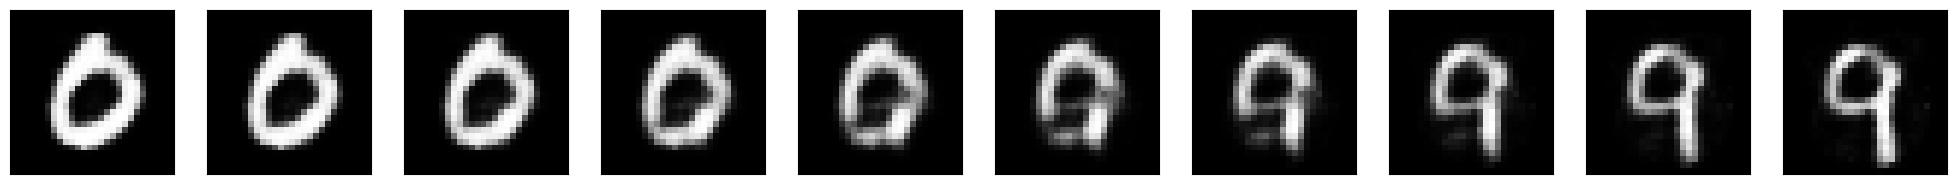

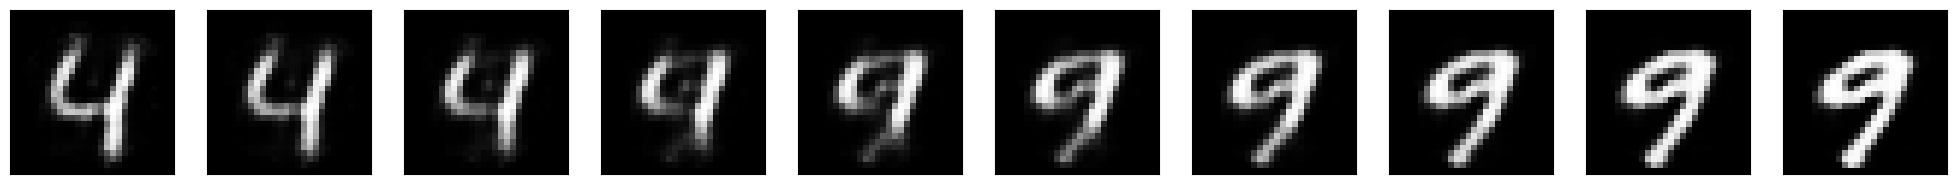

In [29]:
# reconstruction along a line joining 2 data samples in the hidden space
model.eval()

with torch.no_grad():
    img1, _ = next(iter(test_loader))
    img2, _ = next(iter(train_loader))

    img1 = img1[:5]
    img2 = img2[:5]
    
    img1 = img1.view(img1.size(0), -1)
    img2 = img2.view(img2.size(0), -1)
    
    img1 = img1.cuda()
    img2 = img2.cuda()
    for i in range(5):
        plot_reconstruction(model, img1[i], img2[i], 64)
    

2. Variational Autoencoder (VAE): Train a VAE (on MNIST dataset) for the tasks of generating
MNIST-like digits. Encoder learns a distribution in 16D space. After successfully training the
VAE, generate 64 images and display. [15 Marks]

In [30]:
# encoder for vae

class encoder_vae(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super(encoder_vae, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc21 = nn.Linear(hidden_size, latent_size)
        self.fc22 = nn.Linear(hidden_size, latent_size)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        mu = torch.sigmoid(self.fc21(x))
        var = 2*torch.sigmoid(self.fc22(x))
        return mu, var

# decoder for vae

class decoder_vae(nn.Module):
    def __init__(self, latent_size, hidden_size, output_size):
        super(decoder_vae, self).__init__()
        self.fc1 = nn.Linear(latent_size, output_size)
        
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        return x
    
class vae(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super(vae, self).__init__()
        self.encoder = encoder_vae(input_size, hidden_size, latent_size)
        self.decoder = decoder_vae(latent_size, hidden_size, input_size)
        
    def reparameterize(self, mu, var):
        std = torch.sqrt(var)
        eps = torch.randn_like(mu)
        return mu + eps * std
    
    def forward(self, x):
        mu, var = self.encoder(x)
        z = self.reparameterize(mu, var)
        x = self.decoder(z)
        return x, mu, var

In [37]:
# train the VAE

model = vae(784, 16, 16)
model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
train_loss = []

def loss_function(x, recon_x, mu, var, epsilon = 1e-8):
    # Calculate the reconstruction loss
    recon_loss = nn.MSELoss()(recon_x, x)
    
    # Calculate the KL divergence
    det = torch.prod (var, dim = 1)
    mu_square = torch.pow(mu, 2)
    KL_Divergence = torch.sum((torch.sum(mu_square, dim=1) + torch.sum (var, dim = 1) - torch.log(det + epsilon))/ x.size(0))
    return 10 * recon_loss + 0.01 * KL_Divergence, recon_loss, KL_Divergence

for epoch in range(num_epochs + 2):
    for i, data in enumerate(train_loader):

        img, _ = data
        img = img.view(img.size(0), -1)
        img = img.cuda()

        output, mu, var = model(img)
        loss, recon_loss, kl_loss = loss_function(img, output, mu, var)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 500 == 0:
            print(f'Epoch: {epoch+1}, Step: {i + 1}, Loss: {loss.item()}, Reconstruction Loss: {recon_loss.item()}, KL Divergence: {kl_loss.item()}')
            train_loss.append(loss.item())

Epoch: 1, Step: 500, Loss: 1.529416799545288, Reconstruction Loss: 0.13008369505405426, KL Divergence: 22.85798454284668
Epoch: 1, Step: 1000, Loss: 0.9671152234077454, Reconstruction Loss: 0.07414459437131882, KL Divergence: 22.56692886352539
Epoch: 1, Step: 1500, Loss: 0.9300299882888794, Reconstruction Loss: 0.07078462839126587, KL Divergence: 22.218368530273438
Epoch: 2, Step: 500, Loss: 0.9208999872207642, Reconstruction Loss: 0.07053042203187943, KL Divergence: 21.559581756591797
Epoch: 2, Step: 1000, Loss: 0.9096325039863586, Reconstruction Loss: 0.06995517015457153, KL Divergence: 21.008079528808594
Epoch: 2, Step: 1500, Loss: 0.8273786306381226, Reconstruction Loss: 0.061818480491638184, KL Divergence: 20.919384002685547
Epoch: 3, Step: 500, Loss: 0.8148801326751709, Reconstruction Loss: 0.060488369315862656, KL Divergence: 20.999649047851562
Epoch: 3, Step: 1000, Loss: 0.7459753155708313, Reconstruction Loss: 0.053349148482084274, KL Divergence: 21.248380661010742
Epoch: 3, S

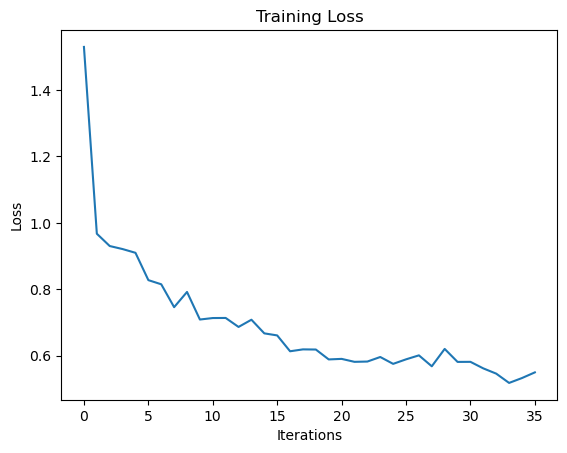

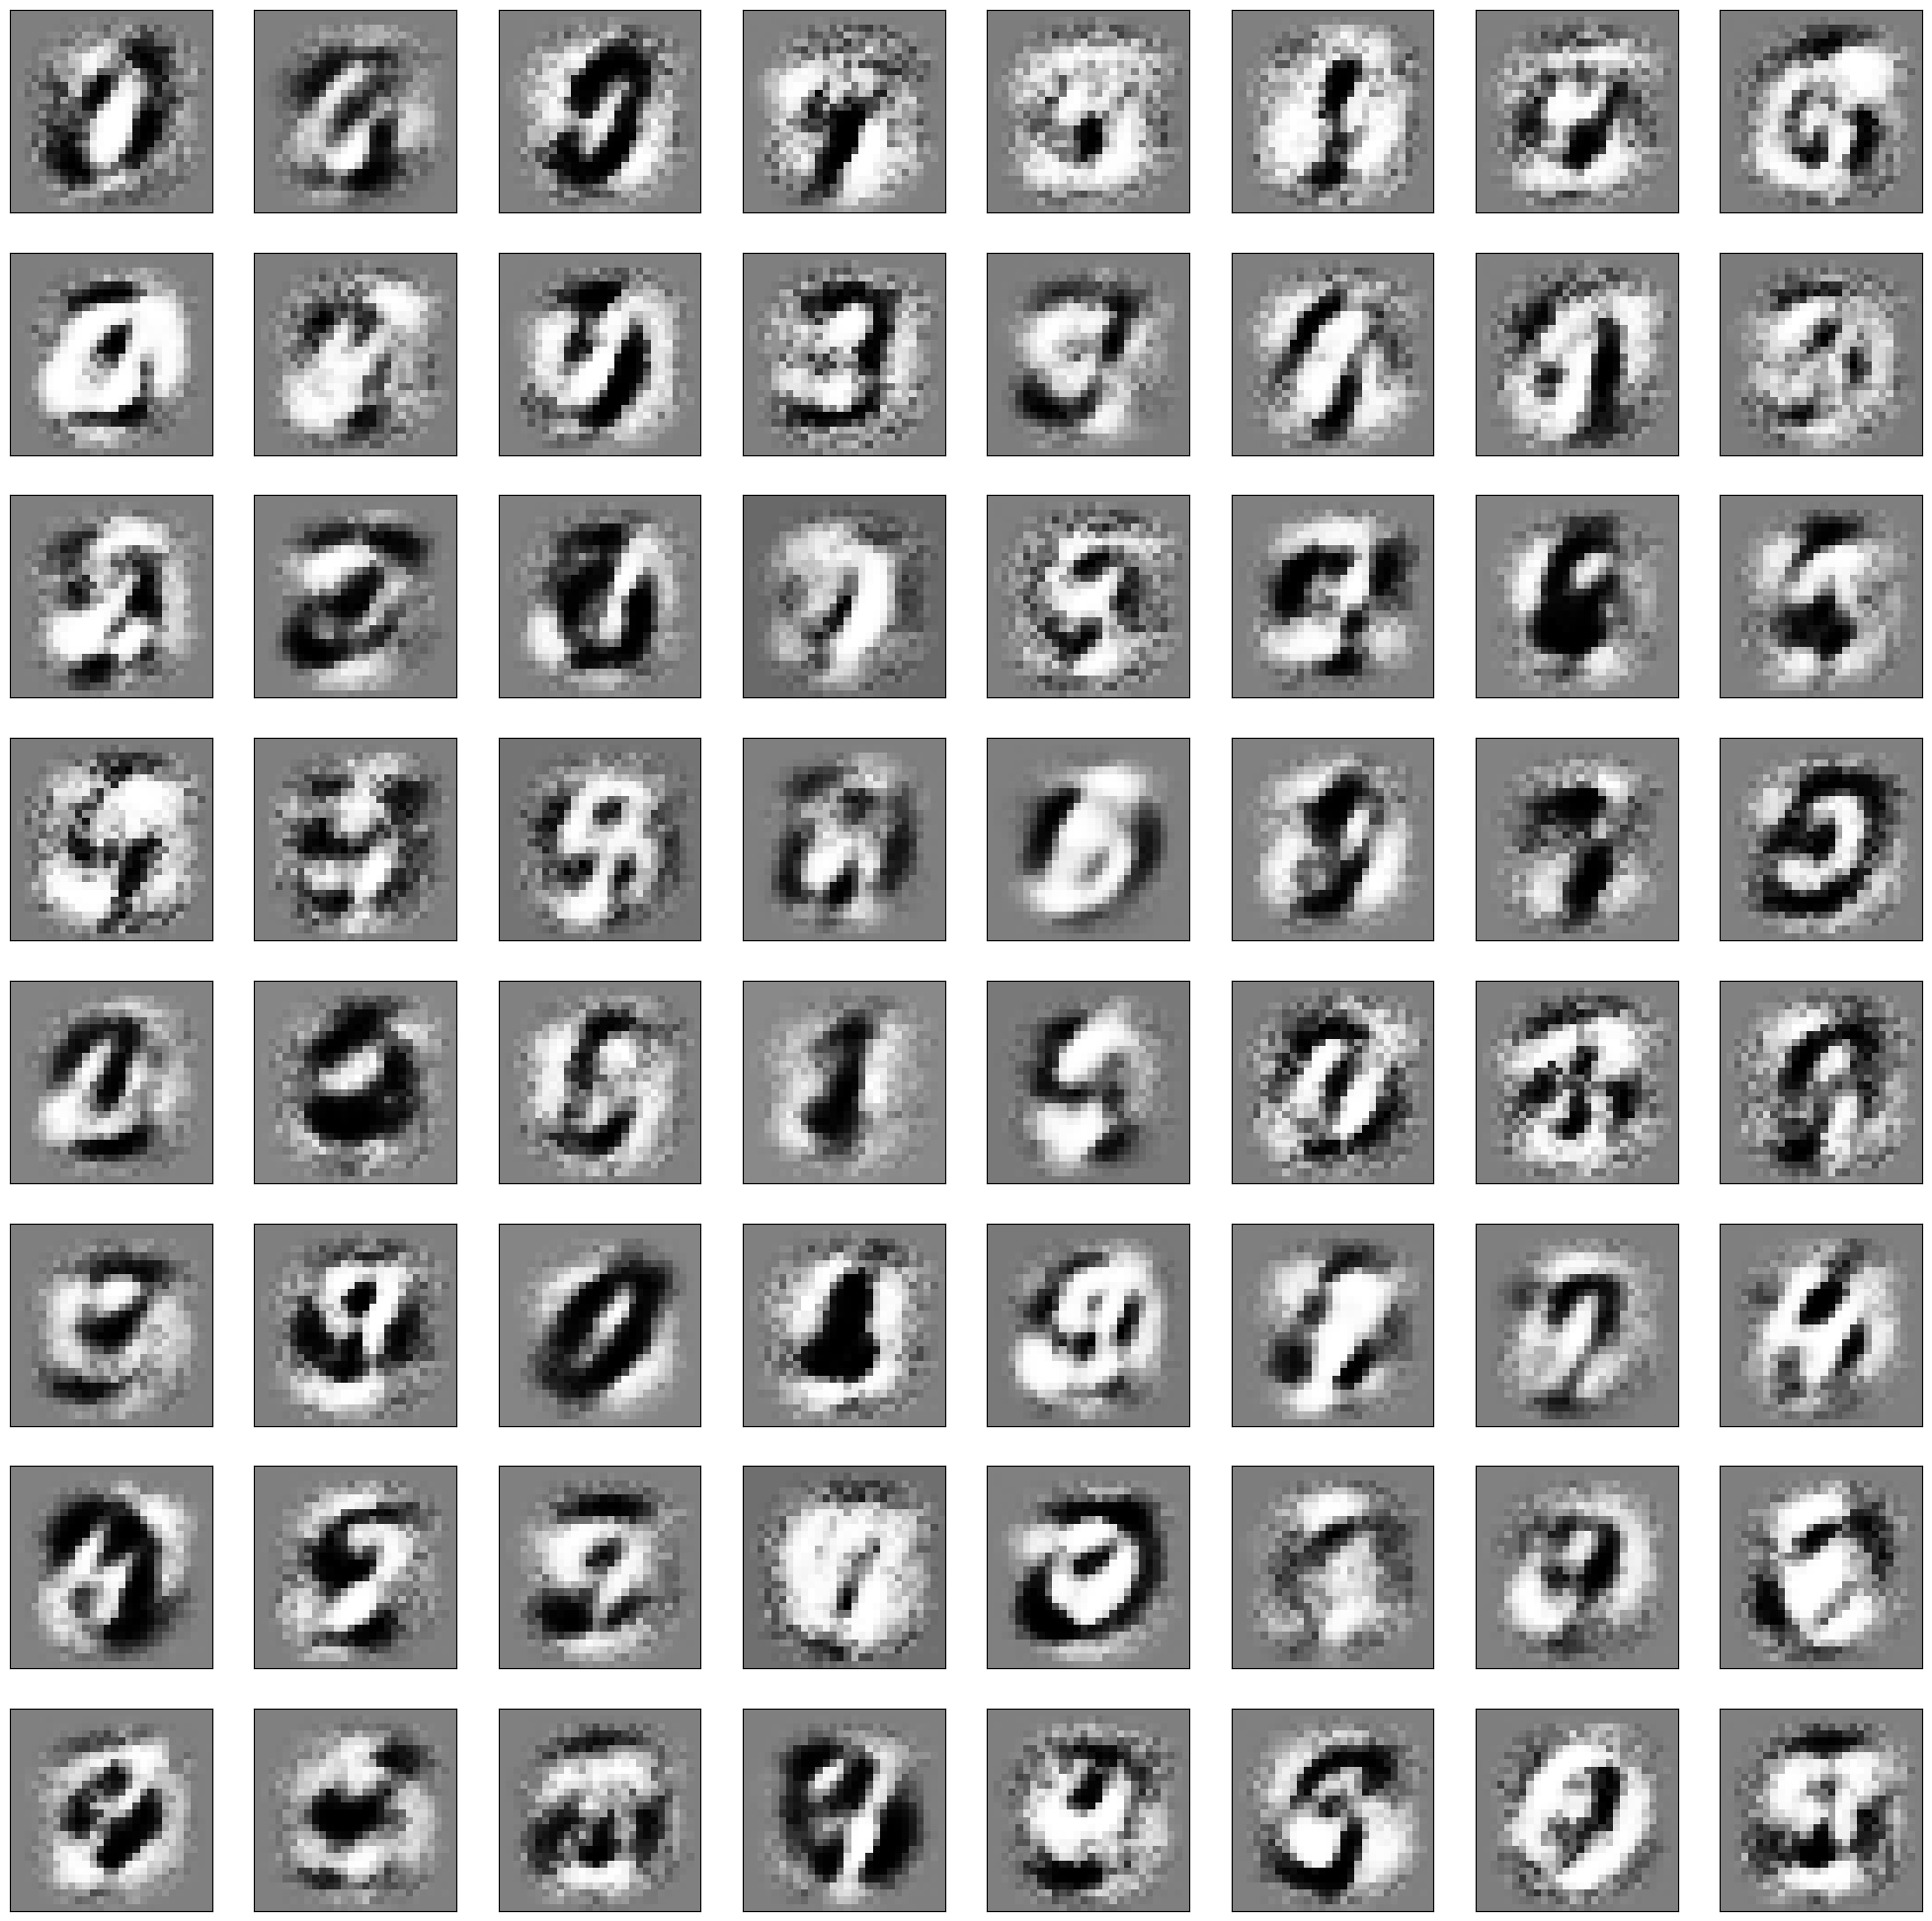

In [40]:
# report train and test reconstruction errors

plt.plot(train_loss)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# test the model

model.eval()
test_loss = []
with torch.no_grad():
    for data in test_loader:
        img, _ = data
        img = img.view(img.size(0), -1)
        img = img.cuda()
        
        noisy_image = add_noise(img, 0.2)
        output, mu, var = model(noisy_image)
        loss, _, _ = loss_function(output, img, mu, var)
        test_loss.append(loss.item())

# generate 64 images and display

model.eval()
with torch.no_grad():
    z = torch.randn(64, 16).cuda()
    output = model.decoder(z)
    
    output = output.view(-1, 28, 28).cpu().numpy()
    
    fig, axes = plt.subplots(nrows=8, ncols=8, sharex=True, sharey=True, figsize=(25,25))
    
    for img, ax in zip(output, axes.flatten()):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
    plt.show()